In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## **CONFIG**

In [79]:
import sys
import os
import yaml
import json

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision.transforms import Resize
import matplotlib.pyplot as plt

from data_preparation import transform_data

In [80]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

IMG_DIR = config['data']['data_dir']
ANNOS_FILE = config['data']['annos_file']
BATCH_SIZE = config['training']['batch_size']
IMG_SIZE = (config['data']['image_size'], config['data']['image_size'])

TRANSFORM = transform_data(IMG_SIZE)
DEVICE = torch.device('cuda') if torch.cuda.is_available else 'cpu'

LR = config['training']['learning_rate']

DISCRIMINANT_CRITERION = nn.CrossEntropyLoss()

NUM_EPOCHS = config['training']['num_epochs']

## **PRE-PROP**

In [81]:
from data_preparation import generate_json_annotations

generate_json_annotations(IMG_DIR, ANNOS_FILE)

folder name: ChestCT
folder name: HeadCT
folder name: Hand
folder name: AbdomenCT
folder name: CXR
folder name: BreastMRI
Annotation process: annotations have been generated successfully and stored in 'annos_train.json'.


## **DATASET \& LOADERS**

In [82]:
from data_preparation import ImageDataset, train_val_dataset, train_val_dataloader

In [104]:
DATASET = ImageDataset(annotations_file='annotations_classif.json',
                      img_dir=IMG_DIR,
                      transform=TRANSFORM)

TRAIN_TEST_SET = train_val_dataset(DATASET, 0.1)
TRAIN_SET = TRAIN_TEST_SET['train']
TRAIN_VAL_SET = train_val_dataset(TRAIN_SET, 0.2)
TRAIN_VAL_LOADER = train_val_dataloader(TRAIN_VAL_SET, BATCH_SIZE)

TEST_SET = TRAIN_TEST_SET['val']

## **TRAINING**

In [84]:
from train import evalutrain_model
from models import FineTunedResNet18

In [85]:
model = FineTunedResNet18()
model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.8)

In [86]:
fit_model, train_losses, train_accs, val_losses, val_accs = evalutrain_model(model,
                'convnet',
                TRAIN_VAL_LOADER,
                TRAIN_VAL_SET,
                DISCRIMINANT_CRITERION,
                optimizer,
                scheduler,
                DEVICE,
                num_epochs=NUM_EPOCHS)

{'train': 47163, 'val': 11791} torch.Size([1, 70, 70])


100%|██████████| 10/10 [04:52<00:00, 29.26s/it]

Training complete in 4m 53s
Best val Acc: 1.000000 during the 9th epoch.



/home/emiliopicard/work/MVA/S1/probabilistic-graphical-models/paper/copy_DeepBayes/PROJECT_CODE/train.py:112: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state

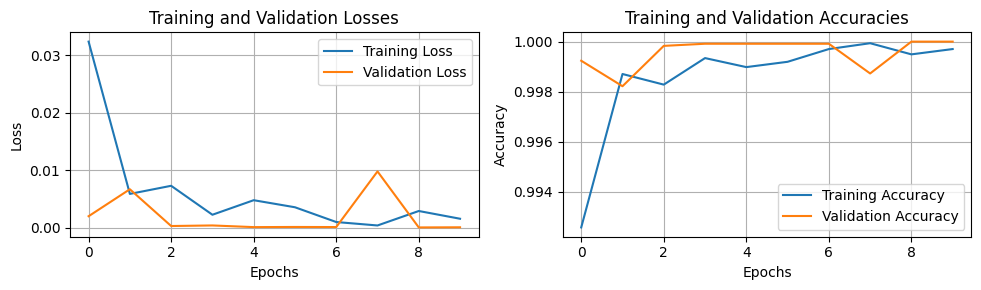

In [101]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Losses')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Training Accuracy')
ax2.plot(val_accs, label='Validation Accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracies')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

In [87]:
torch.save(fit_model.state_dict(), 'model_state_dict_convnet.pth')
torch.save(optimizer.state_dict(), 'optimizer_state_dict_convnet.pth')

# Inférence

100%|██████████| 5896/5896 [01:32<00:00, 63.44it/s] 


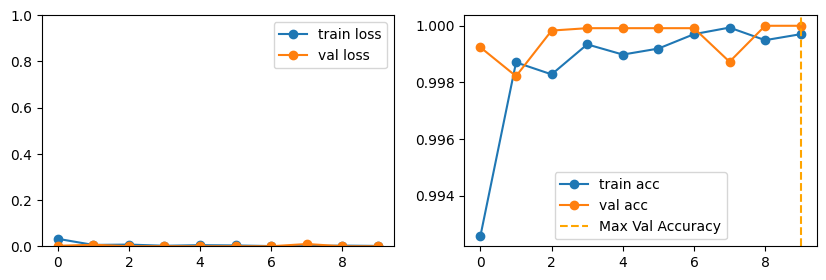

In [109]:
from evaluation import test_evaluation

true_labels, pred_labels, probs_positive = test_evaluation(fit_model, 
                                                            TEST_SET, 
                                                            train_losses,
                                                            train_accs,
                                                            val_losses,
                                                            val_accs,
                                                            device='cpu')

<Figure size 800x600 with 0 Axes>

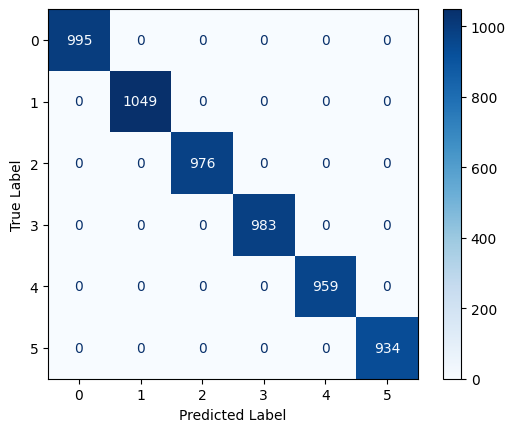

In [113]:
from evaluation import plot_confusion_matrix

cm = plot_confusion_matrix(true_labels, pred_labels)

In [ ]:
from echopict.plot import plot_models

models = ['ResNet34',
          'ResNet50',
          'ResNet152',
          'EfficientNetB7',
          'GoogleNet',
          'VGG',
          'Inception',
          'Vit l 2020',
          'DEIT'
         ]
num_parameters = [2.1, 2.3, 6.0, 6.6, 0.56, 14.3, 2.5, 30.6, 8.6]
accuracies = [0.94, 0.96, 0.89, 0.89, 0.89, 0.90, 0.91, 0.96, 0.92]
AUC = [0.88, 0.91, 0.71, 0.75, 0.77, 0.61, 0.70, 0.89, 0.79]
f1_score = [0.87, 0.90, 0.6, 0.78, 0.75, 0.61, 0.46, 0.87, 0.76]

plot_models(models,  num_parameters, accuracies, AUC, f1_score)
plt.show()